<a href="https://colab.research.google.com/github/Erayboy/Beyoncify/blob/main/IdentifyBeyonce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#the libraries that are needed
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.7MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 194kB 22.3MB/s 
     |████████████████████████████████| 1.2MB 38.5MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 12.8MB 31.1MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
#for getting the urls and storing the images
Imagepath = Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage')
URLpath = Path('/content/gdrive/MyDrive/Colab Notebooks/Data/Beyonce')

In [ ]:
url_file = URLpath/'Beyonce.csv'


In [ ]:
download_images(Imagepath, url_file, max_pics=300)

In [ ]:
Imagepath.ls()

(#239) [Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000004.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000001.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000006.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000002.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000003.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000008.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000007.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000005.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000009.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000011.jpg')...]

In [ ]:
fns = get_image_files(Imagepath)
len(fns)
failed = verify_images(fns)
failed.map(Path.unlink)
??get_image_files

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [ ]:
Beyonce = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = Beyonce.dataloaders(Imagepath)
blocks=(ImageBlock, CategoryBlock)

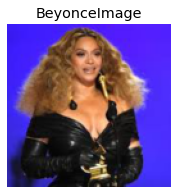

In [ ]:
dls.valid.show_batch(max_n=1, nrows=1)

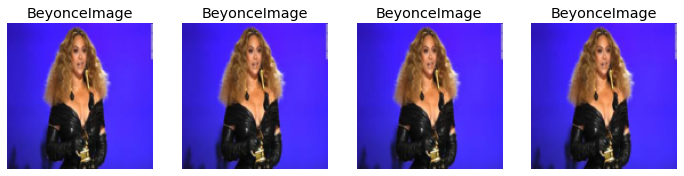

In [ ]:
Beyonce = Beyonce.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = Beyonce.dataloaders(Imagepath)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

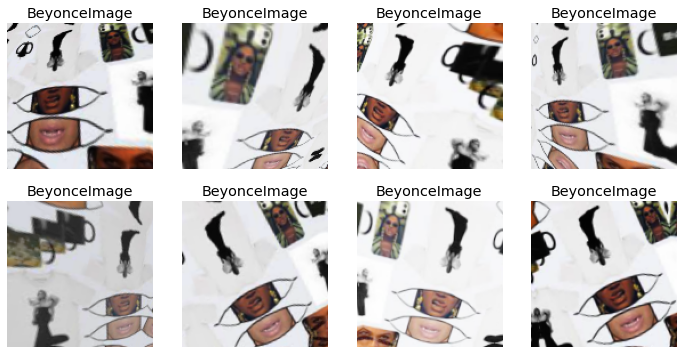

In [ ]:
Beyonce = Beyonce.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = Beyonce.dataloaders(Imagepath)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,01:03
1,0.000000,0.000000,0.000000,01:03
2,0.000000,0.000000,0.000000,01:03
3,0.000000,0.000000,0.000000,01:02


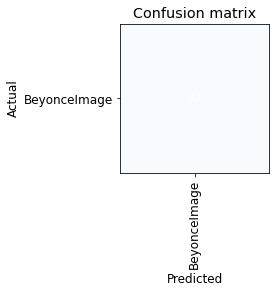

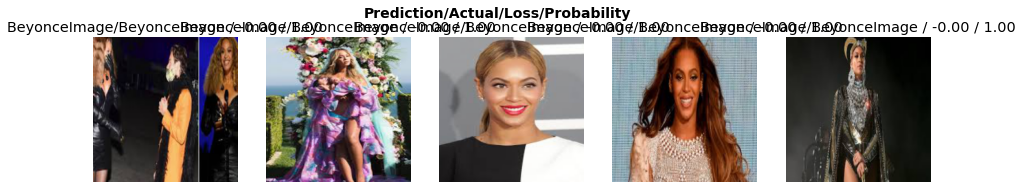

In [ ]:
Beyonce = Beyonce.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = Beyonce.dataloaders(Imagepath)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


In [ ]:
#making an app out of it!
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000001.jpg')

('BeyonceImage', tensor(0), tensor([1.]))

In [ ]:
learn_inf.dls.vocab

['BeyonceImage']

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
btn_upload = SimpleNamespace(data = ['/content/gdrive/MyDrive/Colab Notebooks/Data/BeyonceImage/00000001.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: BeyonceImage; Probability: 1.0000')

In [ ]:
btn_run = widgets.Button(description='Beyoncify')
btn_run

Button(description='Beyoncify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Where is Beyonce?'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 2.5MB 7.3MB/s 
     |████████████████████████████████| 122kB 32.6MB/s 
     |████████████████████████████████| 378kB 37.0MB/s 
     |████████████████████████████████| 552kB 30.2MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 
ERROR: nbdev 1.1.13 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: jupyter-server 1.5.1 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
